In [21]:
import numpy as np
import matplotlib.pyplot as plt
import cvxpy as cp
from admm import run_admm
%load_ext pyinstrument

# autoreload for debugging
%load_ext autoreload
%autoreload 2

%matplotlib inline
%config InlineBackend.figure_formats = ['svg']

The pyinstrument extension is already loaded. To reload it, use:
  %reload_ext pyinstrument
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# generate a gaussian mixture model with 2 components, one with weight .8 and
# the other with weight .2. The mean of the first should be .2, and the mean of 
# the second should be -.2. There should be d dimensions, and the covariance is
# the identity in the first, and sigma * identity in the second.
def generate_gmm(m, d, sigma):
    X = np.random.randn(m, d)
    y = np.random.binomial(1, .8, m)
    X[y == 1] += .2
    X[y == 0] -= .2
    X[y == 0] *= sigma

    # compute the empirical covariance matrix
    P = np.cov(X.T)
    # compute the mean of the data
    q = np.mean(X, axis=0)
    
    return -X, P, -q

In [3]:
np.random.seed(0)
m = 100_000
d = 1000
A, P, q = generate_gmm(m, d, 2)

beta = .1
kappa = .2

k = int(beta * m)
alpha = kappa * k

gamma = .05

A_box = np.eye(d)
A_total = np.ones((1, d))

def box_prox(z):
    return np.clip(z, 0, lim)

def total_prox(z):
    return np.clip(z, 0, 1)

proj_As = [A_box, A_total]
proj_fns = [box_prox, total_prox]

lim = 1
def gen_constraints(x):
    return [
        0 <= cp.sum(x), cp.sum(x) <= 1,
        0 <= x, x <= lim,
    ]

def gen_objective(x):
    return cp.Minimize(.5 * cp.quad_form(x, gamma*P) + q @ x)

In [4]:
q.max(), q.min(), kappa, A.max(), A.min()

(-0.06746340212706711,
 -0.09354192348533061,
 0.2,
 10.919361215062876,
 -10.490861349815166)

In [5]:
# solve the problem with cvxpy for reference
x_cvxpy = cp.Variable(d)
objective = gen_objective(x_cvxpy)
constraints = gen_constraints(x_cvxpy)
constraints += [
    cp.sum_largest(A@x_cvxpy, k) <= alpha ,
]
prob = cp.Problem(objective, constraints)
prob.solve(solver=cp.MOSEK, verbose=True)
print(prob.value)
# print the sum of the largest k elements of A @ x_cvxpy.value
print(np.sort(A @ x_cvxpy.value)[::-1][:k].sum() / m, kappa)

                                     CVXPY                                     
                                     v1.3.0                                    
(CVXPY) Apr 27 10:38:55 PM: Your problem has 1000 variables, 5 constraints, and 0 parameters.
(CVXPY) Apr 27 10:38:55 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Apr 27 10:38:55 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Apr 27 10:38:55 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Apr 27 10:38:55 PM: Compiling problem (target solver=MOSEK).
(CVXPY) Apr 27 10:38:55 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing

In [6]:
# warm start with fewer scenarios
m_ = 1_000
A_ = A[:m_]
k_ = int(beta * m_)
alpha_ = kappa * k_
x_cvxpy_ = cp.Variable(d)

objective_ = gen_objective(x_cvxpy_)
constraints_ = gen_constraints(x_cvxpy_)
constraints_ += [
    cp.sum_largest(A_@x_cvxpy_, k_) <= alpha_ , 
]
prob_ = cp.Problem(objective_, constraints_)
prob_.solve(solver=cp.MOSEK)
print(prob_.value)
print(np.sort(A_ @ x_cvxpy_.value)[::-1][:k].sum() / m_, kappa)

-0.07989145829149212
-0.1285348116740664 0.2


In [23]:
%%pyinstrument

x, history = run_admm(
     gamma*P, q, A, beta, kappa, proj_As, proj_fns, 
     max_iter=1000, 
     alpha_over=1.7, rho=1, 
     warm=x_cvxpy_.value, 
     # constraint_func=gen_constraints
)

print(history["objval"][-1])
print(np.sort(A @ x)[::-1][:k].sum() / m, kappa)

print("relative objective error: ", abs(history["objval"][-1] - prob.value) / abs(prob.value))

iter: 0, objval: -0.07990290264307388, r_norm: 3.7444016160126155, s_norm: 511.8909908806071, u_norm: 3.744767131215031, time: 2.5154662132263184
iter: 100, objval: -0.016987577613698623, r_norm: 0.014841326585388195, s_norm: 1.3012587214564366, u_norm: 0.8465461139859045, time: 5.110101222991943
iter: 200, objval: -0.027167040307879167, r_norm: 0.015440770043681157, s_norm: 0.6557653054390312, u_norm: 0.43794308265828247, time: 7.681745290756226
iter: 300, objval: -0.03437843417637301, r_norm: 0.0033712216534294063, s_norm: 0.053994272811455656, u_norm: 0.050236398774931336, time: 10.29923415184021
iter: 400, objval: -0.03628769079597461, r_norm: 0.001083671329920627, s_norm: 0.020996232213803544, u_norm: 0.026914355580071145, time: 12.9051513671875
iter: 500, objval: -0.0366090659203713, r_norm: 0.0005807909049760523, s_norm: 0.005190405763761609, u_norm: 0.04691097248541017, time: 15.477514028549194
iter: 600, objval: -0.036639719335068856, r_norm: 0.00027481116439879495, s_norm: 0.

_     ._   __/__   _ _  _  _ _/_   Recorded: 23:21:12  Samples:  2904
 /_//_/// /_\ / //_// / //_'/ //     Duration: 18.132    CPU time: 73.982
/   _/                      v4.6.2

Program: /opt/miniconda3/lib/python3.9/site-packages/ipykernel_launcher.py --f=/Users/davidper/Library/Jupyter/runtime/kernel-v2-593Uwx0vHzwvUmJ.json

18.131 <module>  ../../../../var/folders/77/7691ll616ml2z8gggz4x9p4c0000gn/T/ipykernel_5096/1999279743.py:2
`- 18.099 run_admm  admm.py:82
   |- 5.270 update_x  admm.py:33
   |  |- 4.785 y_1  admm.py:75
   |  `- 0.456 factor_solve  admm.py:30
   |     `- 0.455 lu_solve  scipy/linalg/_decomp_lu.py:87
   |           [2 frames hidden]  scipy
   |- 4.680 over_relax_z_hat  admm.py:157
   |- 4.417 proj_sum_largest_cpp  cvar_proj.py:149
   |  `- 4.417 _sort_z  cvar_proj.py:17
   |     `- 4.417 argsort  <__array_function__ internals>:2
   |           [4 frames hidden]  <__array_function__ internals>, numpy...
   |              4.417 ndarray.argsort  <built-in>
   |- 1.905 [self]  admm.py
   |- 0.827 <listcomp>  admm.py:170
   |- 0.521 array  <built-in>
   |- 0.193 _amin  numpy/core/_methods.py:42
   |     [2 frames hidden]  numpy, <built-in>
   `- 0.189 _amax  numpy/core/_methods.py:38
         [2 frames hidden]  numpy, <built-in>

In [14]:
history.keys()

dict_keys(['iter', 'objval', 'r_norm', 's_norm', 'eps_pri', 'eps_dual', 'rho'])

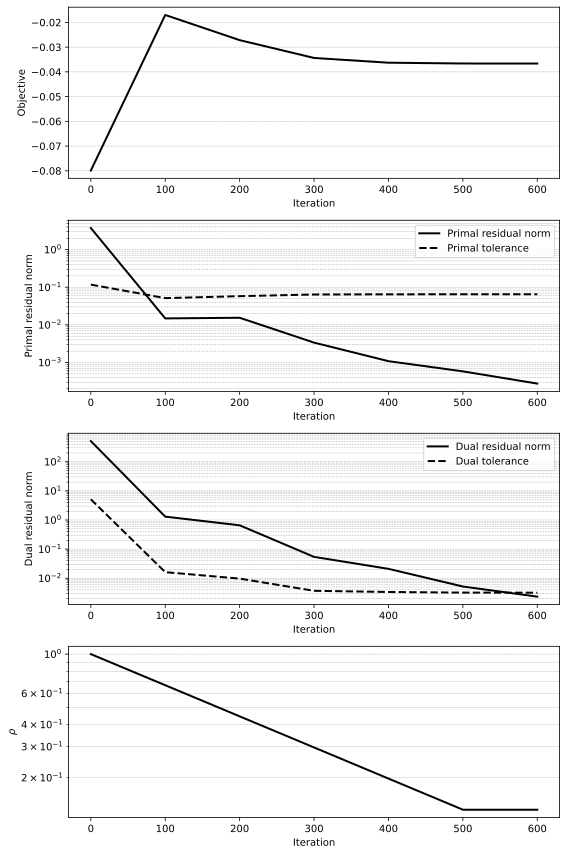

In [30]:
fig, axs = plt.subplots(4, 1, figsize=(8, 12))

# Objective value
axs[0].plot(history['iter'], history['objval'], 'k', markersize=10, linewidth=2, label="ADMM")
axs[0].set_ylabel("Objective")
axs[0].set_xlabel('Iteration')
axs[0].grid(True, which='both', axis='y', linestyle='--', linewidth=0.5)

# Primal residual norm
axs[1].semilogy(history['iter'], history['r_norm'], 'k', linewidth=2, label="Primal residual norm")
axs[1].semilogy(history['iter'], history['eps_pri'], 'k--', linewidth=2, label="Primal tolerance")
axs[1].set_ylabel(r'Primal residual norm')
axs[1].set_xlabel('Iteration')
axs[1].grid(True, which='both', axis='y', linestyle='--', linewidth=0.5)
axs[1].legend()

# Dual residual norm
axs[2].semilogy(history['iter'], history['s_norm'], 'k', linewidth=2, label="Dual residual norm")
axs[2].semilogy(history['iter'], history['eps_dual'], 'k--', linewidth=2, label="Dual tolerance")
axs[2].set_ylabel(r'Dual residual norm')
axs[2].set_xlabel('Iteration')
axs[2].grid(True, which='both', axis='y', linestyle='--', linewidth=0.5)
axs[2].legend()


# ADMM penalty parameter
axs[3].semilogy(history['iter'], history['rho'], 'k', linewidth=2, label="ADMM 1.0")
axs[3].set_ylabel(r'$\rho$')
axs[3].set_xlabel('Iteration')
axs[3].grid(True, which='both', axis='y', linestyle='--', linewidth=0.5)

plt.tight_layout()
plt.show()

In [10]:
x.min(), x.max(), x.sum(), x_cvxpy.value.min(), x_cvxpy.value.max(), x_cvxpy.value.sum()

(-4.058988670043457e-05,
 0.0017955013167489486,
 0.44413998072013217,
 1.4196733738057856e-08,
 0.001807553427201502,
 0.4435903935263111)

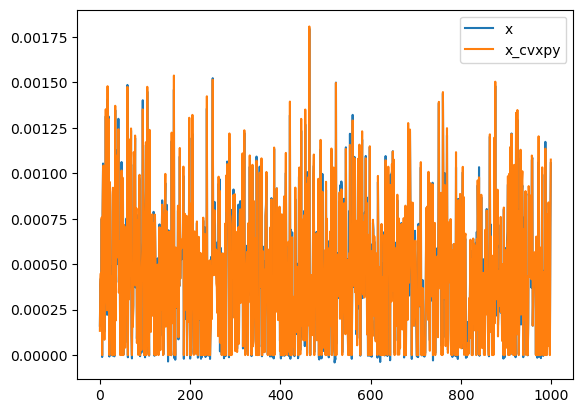

In [11]:
plt.plot(x, label="x")
plt.plot(x_cvxpy.value, label="x_cvxpy")
plt.legend()